## ADA PROJECT - PEPS

# 1.1.1 Genres

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
tqdm.pandas()
import json
from collections import defaultdict
from transformers import pipeline
import ast
import plotly.express as px
import plotly.graph_objects as go

# not displaying warnings
pd.options.mode.chained_assignment = None 

# to facilitate the use of py files
%load_ext autoreload
%autoreload 2

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
DATA_FOLDER_PATH = 'src/data/raw_data/'
CLUSTER_JSON_PATH =  'src/data/clusters.json'

RAW_DATA_FOLDER_PATH = 'data/raw/'
PROCESSED_DATA_FOLDER_PATH = 'data/processed/'
EXTERNAL_DATA_FOLDER_PATH = 'data/external/'
CLUSTER_JSON_PATH =  'data/raw/clusters.json'

In [4]:
from src.data.data_loader import load_csv, load_txt

## Loading data about movie directors

In [5]:
movies_directors_combined = load_csv(PROCESSED_DATA_FOLDER_PATH +'movies_directors_combined.csv')

Loaded data from data/processed/movies_directors_combined.csv, shape: (39517, 11)


In [6]:
movies_director = load_csv(PROCESSED_DATA_FOLDER_PATH + 'movies_director.csv', has_column_names=False, column_names=['wikipedia_movie_id', 'director_name', 'director_gender'])[1:]
movies_director['wikipedia_movie_id'] = movies_director['wikipedia_movie_id'].astype(int)

Loaded data from data/processed/movies_director.csv, shape: (39518, 3)


## Genres according to movie director gender

In [7]:
movies_directors_combined.head(3)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,director_name,director_gender
0,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,['English'],['United Kingdom'],['Thriller'],Donald Cammell,M
1,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,['German'],['Germany'],['Drama'],Robert van Ackeren,M
2,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['English'],['United States'],"['Music and Dance', 'Comedy', 'Black-and-white']",Henry King,M


In [8]:
movies_directors_combined['movie_genres'] = movies_directors_combined['movie_genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

## 1.1.1.1 Global disitribution movie genres (both produced by male and female directors all together)

In [9]:
all_genres = [genre for sublist in movies_directors_combined['movie_genres'] for genre in sublist]
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

genre_df = genre_df.sort_values(by='Count', ascending=False)
# keep only the genres with more than 500 movies
genre_df = genre_df[genre_df['Count'] > 500]

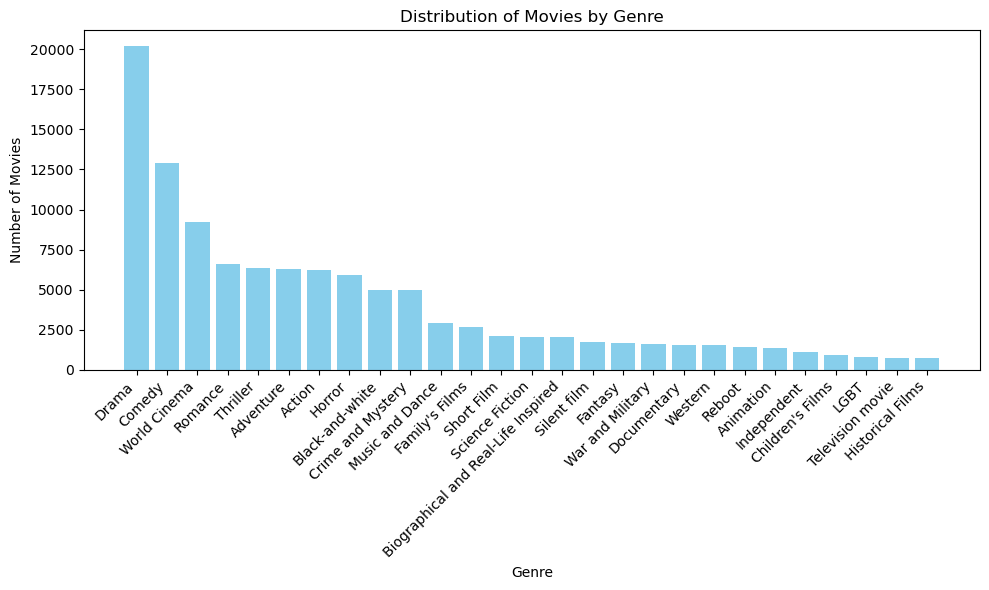

In [10]:
# Plot the distribution of genres
plt.figure(figsize=(10, 6))
plt.bar(genre_df['Genre'], genre_df['Count'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 1.1.1.2 Genres depending on movie director gender

## Let us seek through the differences between films maked by male and female directors

First, we split the data between movies produced by males and females

In [11]:
# explode : unfold the list 
# astype(str) : cast to string 
male_directed_genres = movies_directors_combined[movies_directors_combined['director_gender'] == "M"]['movie_genres'].explode().unique().astype(str)
female_directed_genres = movies_directors_combined[movies_directors_combined['director_gender'] == "F"]['movie_genres'].explode().unique().astype(str)

In [12]:
Only_male_directed_genres = []
for genre in male_directed_genres:
    if genre not in female_directed_genres:
        Only_male_directed_genres.append(genre)

print(f'The following genres are only directed by men:\n {Only_male_directed_genres}')

Only_female_directed_genres = []
for genre in female_directed_genres:
    if genre not in male_directed_genres:
        Only_female_directed_genres.append(genre)

print(f'The following genres are only directed by women:\n {Only_female_directed_genres}')


## AUTRE METHODE ##
all_genres = movies_directors_combined['movie_genres'].explode().unique().astype(str)

genres_no_female_dir = np.setdiff1d(all_genres, female_directed_genres)
genres_no_male_dir = np.setdiff1d(all_genres, male_directed_genres)


The following genres are only directed by men:
 ['Plague', 'Star vehicle', 'Albino bias', 'Mondo film', 'Coming-of-age film', 'Inventions & Innovations', 'Kafkaesque', 'Therimin music', 'Bruceploitation', 'Roadshow/Carny', 'Health & Fitness']
The following genres are only directed by women:
 []


Hence, we see that a few (11) genres are only directed by men. At first glance, this may seem trivial: however, we can look at the cinematogrpahic genres not exploited by women: why don't women direct any films on health and fitness? 

In [13]:
#list of genres for movies directed by men
movies_director_m = movies_directors_combined[movies_directors_combined['director_gender'] == "M"]
all_genres_m = [genre for sublist in movies_director_m['movie_genres'] for genre in sublist]
genre_counts_m = Counter(all_genres_m)

genres_df_m = pd.DataFrame(genre_counts_m.items(), columns=['Genre', 'Count_m'])

#list of genres for movies directed by women
movies_director_f = movies_directors_combined[movies_directors_combined['director_gender'] == "F"]
all_genres_f = [genre for sublist in movies_director_f['movie_genres'] for genre in sublist]
genre_counts_f = Counter(all_genres_f)

genres_df_f = pd.DataFrame(genre_counts_f.items(), columns=['Genre', 'Count_f'])

## Then, we look at the respective disitrbution of movie genres for each genders

First, we consider the movies directed by women

In [25]:
genres_df_f

,Genre,Count_f
0,Drama,2332
1,Black-and-white,298
2,Adventure,364
3,World Cinema,1269
4,Independent,98
5,Comedy,1198
6,War and Military,105
7,Biographical and Real-Life Inspired,197
8,Romance,875
9,Crime and Mystery,345


In [15]:
#genres_df_f = genres_df_f.sort_values('Count_f', ascending=False).head(X) to have a the X top of genres

# Calculate proportions
genres_df_f['Proportion'] = genres_df_f['Count_f'] / genres_df_f['Count_f'].sum()

# Create the pie chart
fig = go.Figure(data=[go.Pie(
    labels=genres_df_f['Genre'],
    values=genres_df_f['Count_f'],
    hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percent}<extra></extra>',
    textinfo='none'
)])

# Update layout
fig.update_layout(
    title='Movie Genres disitrbution - female directors',
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="Rockwell"
    )
)

fig.show()


Among the films directed by women, the following four genres stand out: 
- Drama: 22.3%
- World Cinema: 12.1%
- Comedy: 11.4%
- Romance: 8.4%

Then, we focus on male-directed movies 

In [16]:
#genres_df_m = genres_df_m.sort_values('Count_f', ascending=False).head(X) to have a the X top of genres

# Calculate proportions
genres_df_m['Proportion'] = genres_df_m['Count_m'] / genres_df_m['Count_m'].sum()

# Create the pie chart
fig = go.Figure(data=[go.Pie(
    labels=genres_df_m['Genre'],
    values=genres_df_m['Count_m'],
    hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percent}<extra></extra>',
    textinfo='none'
)])

# Update layout
fig.update_layout(
    title='Movie Genres disitrbution - male directors',
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="Rockwell"
    )
)

fig.show()

Among films direct by men, we noticed that the distribution by movie genre is more uniform: however, the most frequent genres are also drama, world cinema and comedy. This can be explained by the fact that these three cinematic genre are quite broad.

# 1.1.1.3 Mixed male/female genre distribution

### Plot the distribution of female and male directors for all genres (both directed by men and women)

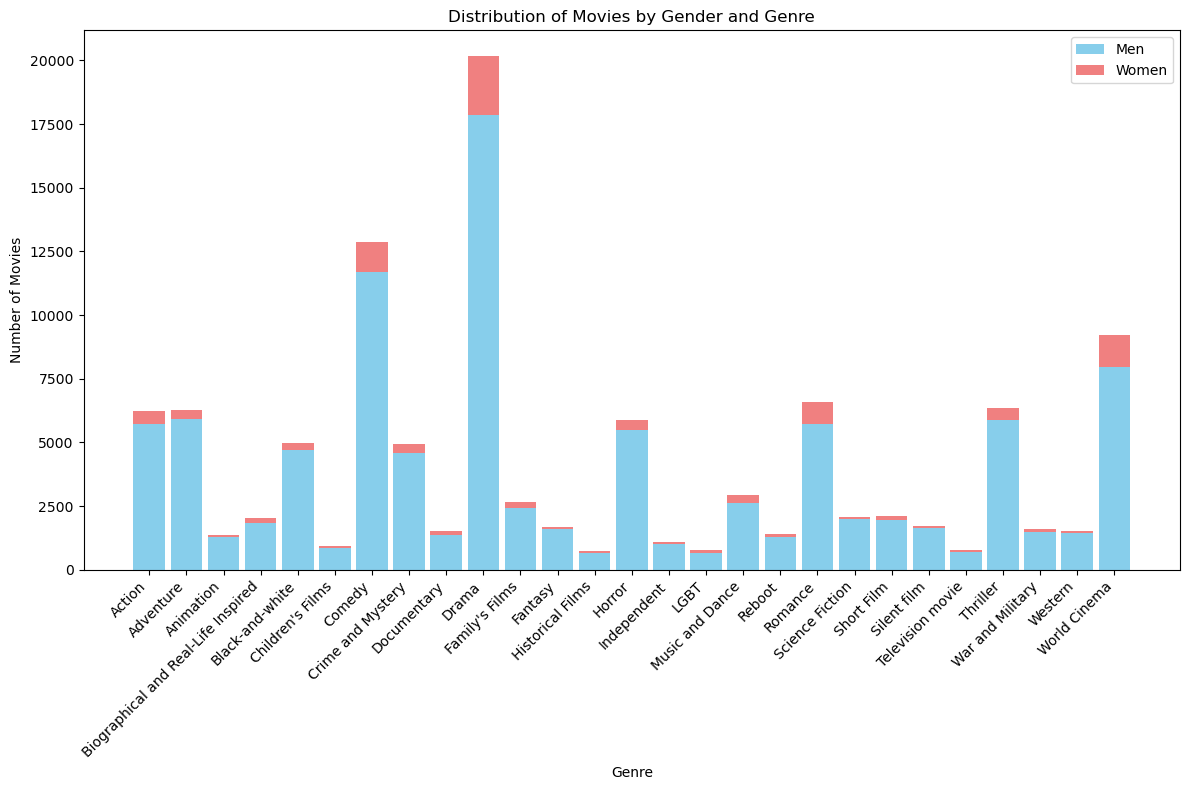

In [17]:
#merge the male and female genre dataframes on the Genre column
genre_df = pd.merge(genres_df_m, genres_df_f, on='Genre', how='outer').fillna(0)

#filter genres with more than 500 movies
genre_df['Total'] = genre_df['Count_m'] + genre_df['Count_f']
genre_df = genre_df[genre_df['Total'] > 500] 

plt.figure(figsize=(12, 8))
bar_width = 0.85
bar_positions = range(len(genre_df))

plt.bar(bar_positions, genre_df['Count_m'], width=bar_width, label='Men', color='skyblue')
plt.bar(bar_positions, genre_df['Count_f'], width=bar_width, label='Women', color='lightcoral', bottom=genre_df['Count_m'])

plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Gender and Genre')
plt.xticks(bar_positions, genre_df['Genre'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


We observe that drama, comedy and world cinema consitute the first three genres produced by women. 
Now, let's see in terms of proportion of movies produced by women vs men.

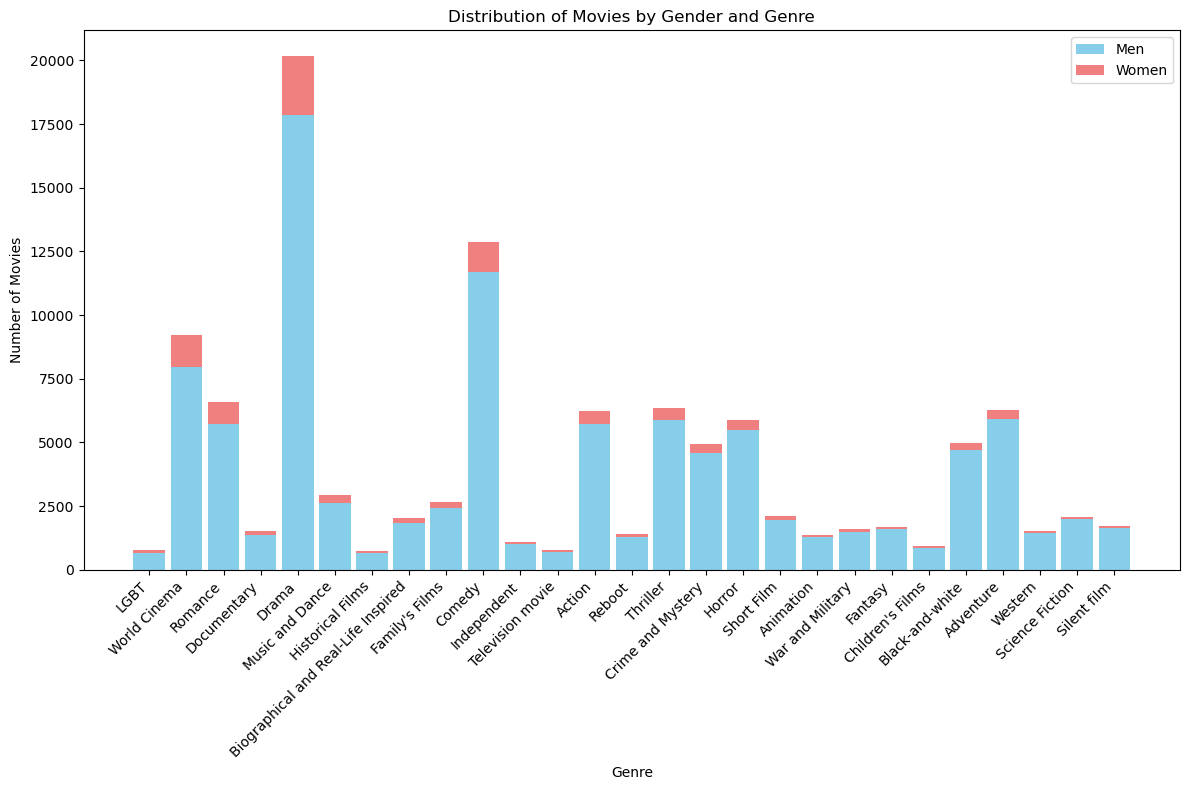

In [18]:
# Calculate the proportion of movies directed by women
genre_df['Proportion_f'] = genre_df['Count_f'] / genre_df['Total']

# Sort genres by the proportion of women directors in descending order
genre_df = genre_df.sort_values(by='Proportion_f', ascending=False)

# Sort genres by the number of movies directed by women in descending order
# genre_df = genre_df.sort_values(by='Count_f', ascending=False)

genre_df = genre_df[genre_df['Total'] > 500] 

plt.figure(figsize=(12, 8))
bar_width = 0.85
bar_positions = range(len(genre_df))

plt.bar(bar_positions, genre_df['Count_m'], width=bar_width, label='Men', color='skyblue')
plt.bar(bar_positions, genre_df['Count_f'], width=bar_width, label='Women', color='lightcoral', bottom=genre_df['Count_m'])

plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Gender and Genre')
plt.xticks(bar_positions, genre_df['Genre'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## Creation of a csv file with all the movies produced by women grouped by genre - utile ?

In [26]:
# Create a list to hold the data for each genre
female_movies_by_genre = []

# Assuming `movies_director_f` contains the movies directed by women with columns 'movie_genres' and 'movie_title'
for genre in genre_df['Genre']:  # genre_df is sorted by proportion of women-directed movies
    movies_in_genre = movies_director_f[
        movies_director_f['movie_genres'].apply(lambda genres: genre in genres)
    ]['movie_name'].tolist()
    female_movies_by_genre.append((genre, movies_in_genre))

# Create a DataFrame with the results
female_movies_df = pd.DataFrame(female_movies_by_genre, columns=['Genre', 'Female_Directed_Movies'])

# Display the DataFrame
pd.set_option('display.max_colwidth', None)  # Ensures long lists are fully displayed

female_movies_df.to_csv('female_directed_movies_by_genre.csv', index=False)

## More detailed graph (chatGPT)

In [20]:
# Flatten the list of genres for movies directed by men
genres_df_m = pd.DataFrame(genre_counts_m.items(), columns=['Genre', 'Count_m'])

# Flatten the list of genres for movies directed by women
all_genres_f = [genre for sublist in movies_director_f['movie_genres'] for genre in sublist]
genre_counts_f = Counter(all_genres_f)

genres_df_f = pd.DataFrame(genre_counts_f.items(), columns=['Genre', 'Count_f'])

# Merge the male and female genre dataframes on the Genre column
genre_df = pd.merge(genres_df_m, genres_df_f, on='Genre', how='outer').fillna(0)

# Calculate the total count and filter genres with more than 500 movies
genre_df['Total'] = genre_df['Count_m'] + genre_df['Count_f']
genre_df = genre_df[genre_df['Total'] > 500]

# Calculate the proportion of movies directed by women
genre_df['Proportion_f'] = genre_df['Count_f'] / genre_df['Total']
genre_df['Proportion_m'] = 1 - genre_df['Proportion_f'] 
# Sort genres by the proportion of women directors in descending order
genre_df = genre_df.sort_values(by='Proportion_f', ascending=False)

# Create an interactive bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=genre_df['Genre'],
    y=genre_df['Count_m'],
    name='Men',
    marker_color='skyblue',
    hoverinfo='y',  # Show only count on hover for this trace
    text=genre_df['Proportion_m'].apply(lambda x: f"{x:.2%}"),  # Add male proportions as text
    textposition='auto',  # Show the text above the bars
))

fig.add_trace(go.Bar(
    x=genre_df['Genre'],
    y=genre_df['Count_f'],
    name='Women',
    marker_color='lightcoral',
    hoverinfo='y',  # Show only count on hover for this trace
    text=genre_df['Proportion_f'].apply(lambda x: f"{x:.2%}"),  # Add female proportions as text
    textposition='auto',  # Show the text above the bars
))

# Update layout
fig.update_layout(
    barmode='stack',
    title='Distribution of Movies by Gender and Genre (Proportions Highlighted)',
    xaxis=dict(title='Genre'),
    yaxis=dict(title='Number of Movies'),
    legend=dict(title='Director Gender'),
    hovermode="x unified"  # Shows hover info for both traces at the same time
)

# Add hovertemplate to display proportions for both men and women
fig.update_traces(
    hovertemplate="<b>Genre:</b> %{x}<br>" +
                  "<b>Proportion:</b> %{text}<br>" +
                  "<b>Count:</b> %{y}<br>"
)

fig.show()


# 1.1.1.4 TV tropes depending on genres